In [1]:
from typing import Tuple

import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, Subset
import torchmetrics

from vae import VariationAutoencoderModule, WassersteinLoss, MultiCategoricalLoss

In [1]:
bottleneck_size = 8
n_layers = 1

list(reversed([bottleneck_size * i * 2 for i in range(1, n_layers + 1)]))

[16]

In [2]:
class UpdrsData(Dataset):
    def __init__(self, path):
        super().__init__()
        data = pd.read_csv(path, sep="\t").sort_values(["PatientID", "Age"])
        measurements = (
            data[[column for column in data.columns if column.startswith("3.")]]
            .dropna()
            .astype(int)
        )
        self.covariates = data.loc[
            measurements.index,
            [
                "PatientID",
                "Age",
                "Deep brain stimulation available",
                "Deep brain stimulation",
                "Medication",
            ],
        ].reset_index(drop=True)
        self.measurements = torch.tensor(measurements.to_numpy(), dtype=torch.float32)

    def __getitem__(self, index):
        return self.measurements[index]

    def __len__(self):
        return len(self.measurements)

    @property
    def participant_covariate(self) -> str:
        return "PatientID"


class UpdrsDataQoL(Dataset):
    COLUMNS = [f"UPDRS 1.{i}" for i in range(1, 14)] + [
        f"UPDRS 2.{i}" for i in range(1, 14)
    ]

    def __init__(self, path):
        super().__init__()
        data = pd.read_csv(path, sep=",").sort_values(["Participant", "Age"])
        measurements = data[UpdrsDataQoL.COLUMNS].dropna().astype(int)
        self.covariates = data.loc[
            measurements.index,
            ["Participant", "Age"],
        ].reset_index(drop=True)
        self.measurements = torch.tensor(measurements.to_numpy(), dtype=torch.float32)

    def __getitem__(self, index):
        return self.measurements[index]

    def __len__(self):
        return len(self.measurements)

    @property
    def participant_covariate(self) -> str:
        return "Participant"


class UpdrsDataModule(L.LightningDataModule):
    def __init__(
        self,
        dataset: Dataset,
        percentage_subjects_in_valid_dataset: float,
        batch_size: int,
    ):
        super().__init__()
        assert 0 < percentage_subjects_in_valid_dataset <= 1

        self.data = dataset
        self.batch_size = batch_size

        if percentage_subjects_in_valid_dataset < 1:
            patients = self.data.covariates[dataset.participant_covariate].unique()
            num_patients_valid = int(
                len(patients) * percentage_subjects_in_valid_dataset
            )
            first_patient_valid = len(patients) - num_patients_valid
            # Find the index of the first patient in valid set
            self.val_start = self.data.covariates[
                self.data.covariates[dataset.participant_covariate]
                == patients[first_patient_valid]
            ].index[0]
        else:
            self.val_start = 0

    def calculate_class_weights(self):
        return torch.tensor(
            compute_class_weight(
                "balanced",
                classes=range(5),
                y=self.data.measurements[: self.val_start].flatten().long().numpy(),
            )
        ).float()

    def train_dataloader(self):
        if self.val_start == 0:
            raise ValueError("Only the validation set is used.")
        return DataLoader(
            Subset(self.data, range(0, self.val_start)),
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=8,
        )

    def val_dataloader(self):
        return DataLoader(
            Subset(self.data, range(self.val_start, len(self.data))),
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=4,
        )


data = UpdrsDataQoL(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp.csv"
)
data_module = UpdrsDataModule(
    data,
    percentage_subjects_in_valid_dataset=0.2,
    batch_size=512,
)
print(len(data_module.train_dataloader()))
print(len(data_module.val_dataloader()))

22
3


## Fit the model

In [ ]:
NAME = "updrs_qol_vae_new"

reconstruction_loss = MultiCategoricalLoss(
    n_values=len(UpdrsDataQoL.COLUMNS),
    n_classes=5,
    is_categorical=False,
    is_ordinal=True,
    weight=data_module.calculate_class_weights().to("cuda"),
)
#generative_loss = KullbackLeiblerLoss(beta=1.0)
generative_loss = WassersteinLoss(reg_weight=100, kernel_type="imq", z_var=2.0)
model = VariationAutoencoderModule(
    reconstruction_loss, generative_loss, [64, 48, 32, 16], patience=80, learning_rate=1e-3, dropout=0.05
)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename=NAME,
    save_top_k=1,
    verbose=True,
    monitor="val_concordance",
    mode="max",
)
early_stopping = EarlyStopping(monitor="val_concordance", patience=120, mode="max")
logger = TensorBoardLogger("logs", name=NAME)

# Initialize the PyTorch Lightning trainer
trainer = L.Trainer(
    max_epochs=1000, callbacks=[early_stopping], logger=logger, log_every_n_steps=6
)

trainer.fit(model, data_module)

## Evaluate the model

In [3]:
model = VariationAutoencoderModule.load_from_checkpoint(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/src/checkpoints/updrs_qol_optuna_77.ckpt"
).model.eval()

### Check its applicability for PDQ prediction

In [4]:
MAX_SCORES = {
    "Mobility": 40,
    "Daily living": 24,
    "Emotion": 24,
    "Stigmatization": 16,
    "Social support": 12,
    "Cognition": 16,
    "Communication": 12,
    "Bodily discomfort": 12,
}
TARGET_COLUMNS = list(MAX_SCORES.keys())

df_amp = pd.read_csv("../data/pdq_amp.csv", na_values="Unknown")
df_amp.columns = df_amp.columns.str.replace("ADL", "Daily living", regex=False)
df_amp.columns = df_amp.columns.str.replace("Stigma", "Stigmatization", regex=False)
df_amp.columns = df_amp.columns.str.replace("Social", "Social support", regex=False)
df_amp.columns = df_amp.columns.str.replace(
    "Discomfort", "Bodily discomfort", regex=False
)

value_map = {
    "Never": 0,
    "Occasionally": 1,
    "Sometimes": 2,
    "Often": 3,
    "Always or cannot do at all": 4,
}

# Convert relevant columns using the map to numerical values
for col in df_amp.columns:
    if col.startswith("PDQ39"):
        df_amp[col] = df_amp[col].map(value_map).astype(pd.Int64Dtype())

for key, value in MAX_SCORES.items():
    selected_columns = df_amp.filter(like=key)
    assert len(selected_columns.columns) * 4 == value
    df_amp[key] = selected_columns.sum(axis=1, skipna=False)
    df_amp[key] = (df_amp[key] * 100) / value
    df_amp = df_amp.drop(columns=selected_columns.columns)


df_amp["PDQ"] = df_amp[TARGET_COLUMNS].mean(axis=1)
df_amp = df_amp.drop(columns=TARGET_COLUMNS)

# Cast the UPDRS scoresx
for col in df_amp.columns:
    if col.startswith("UPDRS"):
        df_amp[col] = df_amp[col].astype(pd.Int64Dtype())
df_amp = df_amp.drop(columns=["MoCA", "UPDRS I", "UPDRS II", "Hoehn and Yahr", "UPDRS III",	"Time with dyskinesias", "Time in off",	"Painful off states"])

UPDRS_I_columns = df_amp.filter(like="UPDRS 1.")
df_amp["UPDRS I"] = (UPDRS_I_columns.sum(axis=1, skipna=False) / (len(UPDRS_I_columns.columns) * 4)) * 100

UPDRS_II_columns = df_amp.filter(like="UPDRS 2.")
df_amp["UPDRS II"] = (UPDRS_II_columns.sum(axis=1, skipna=False) / (len(UPDRS_II_columns.columns) * 4)) * 100

# df_amp = df_amp.drop(columns=UPDRS_columns.columns)
df_amp = df_amp.dropna(subset=["PDQ", "UPDRS I", "UPDRS II"])

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error
import seaborn as sns

X = df_amp[[column for column in df_amp.columns if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")]].to_numpy().astype(float)
y = df_amp["PDQ"].to_numpy()

X_feature = model(torch.tensor(X, dtype=torch.float32).to("cuda")).z_dist.loc.cpu().detach().numpy()

folds = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
representation_results = []
for name, regressor in {
    "Linear": LinearRegression(),
    "Ensemble": HistGradientBoostingRegressor(loss="absolute_error")
}.items():
    for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        regressor.fit(X_feature[train_index], y[train_index])
        representation_results.append(pd.DataFrame({"PDQ: Ground truth": y[test_index], "PDQ: Prediction": regressor.predict(X_feature[test_index]), "Method": name, "Fold": fold}))

representation_results = pd.concat(representation_results)
representation_results["Input"] = "Representation"

representation_results

,PDQ: Ground truth,PDQ: Prediction,Method,Fold,Input
0,31.197917,21.910496,Linear,0,Representation
1,25.416667,9.602708,Linear,0,Representation
2,15.677083,14.009796,Linear,0,Representation
3,25.833333,10.322022,Linear,0,Representation
4,30.520833,17.089256,Linear,0,Representation
...,...,...,...,...,...
318,5.781250,6.072854,Ensemble,9,Representation
319,1.041667,10.656394,Ensemble,9,Representation
320,3.125000,6.492863,Ensemble,9,Representation
321,4.479167,2.845843,Ensemble,9,Representation


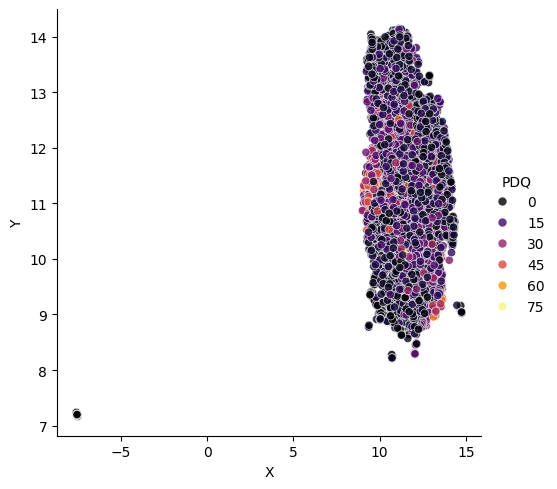

In [6]:
from umap import UMAP

projected_data = pd.DataFrame.from_records(UMAP(n_neighbors=30, min_dist=0.05, n_components=2, target_metric="l1").fit_transform(X_feature, y=df_amp[["UPDRS I", "UPDRS II"]].mean(axis=1).to_numpy()), columns=["X", "Y"])
projected_data["PDQ"] = y   
sns.relplot(data=projected_data, x="X", y="Y", hue="PDQ", alpha=0.8, palette="inferno")

In [29]:
df_amp.columns

Index(['Participant', 'Visit ID', 'Age (Diagnosis)', 'Age', 'Diagnosis',
       'Study', 'Surgery', 'Medication', 'Sex', 'Education', 'UPDRS 1.1',
       'UPDRS 1.2', 'UPDRS 1.3', 'UPDRS 1.4', 'UPDRS 1.5', 'UPDRS 1.6',
       'UPDRS 1.7', 'UPDRS 1.8', 'UPDRS 1.9', 'UPDRS 1.10', 'UPDRS 1.11',
       'UPDRS 1.12', 'UPDRS 1.13', 'UPDRS 2.1', 'UPDRS 2.2', 'UPDRS 2.3',
       'UPDRS 2.4', 'UPDRS 2.5', 'UPDRS 2.6', 'UPDRS 2.7', 'UPDRS 2.8',
       'UPDRS 2.9', 'UPDRS 2.10', 'UPDRS 2.11', 'UPDRS 2.12', 'UPDRS 2.13',
       'PDQ', 'UPDRS I', 'UPDRS II'],
      dtype='object')

In [7]:
def calculate_predictions(df_amp: pd.DataFrame, columns_individual, columns_scores, input_type: str) -> pd.DataFrame:
    X = df_amp[columns_individual]
    y = df_amp["PDQ"].to_numpy()
    folds = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

    results = []

    # Check the baseline condition on scores
    for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        regressor = LinearRegression()
        regressor.fit(df_amp[columns_scores].iloc[train_index], y[train_index])
        results.append(pd.DataFrame({"PDQ: Ground truth": y[test_index], "PDQ: Prediction": regressor.predict(df_amp[columns_scores].iloc[test_index]), "Method": "Linear (score)", "Fold": fold}))
    
    # Use the individual values
    for name, regressor in {
        "Linear": LinearRegression(),
        "Ensemble": HistGradientBoostingRegressor(loss="absolute_error")
    }.items():
        for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
            regressor.fit(X.iloc[train_index], y[train_index])
            results.append(pd.DataFrame({"PDQ: Ground truth": y[test_index], "PDQ: Prediction": regressor.predict(X.iloc[test_index]), "Method": name, "Fold": fold}))
    
    result = pd.concat(results)
    result["Input"] = input_type
    return result

results_updrs_i = calculate_predictions(df_amp, [column for column in df_amp.columns if column.startswith("UPDRS 1.")], ["UPDRS I"], "UPDRS I only")
results_updrs_ii = calculate_predictions(df_amp, [column for column in df_amp.columns if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")], ["UPDRS I", "UPDRS II"], "UPDRS I and II")

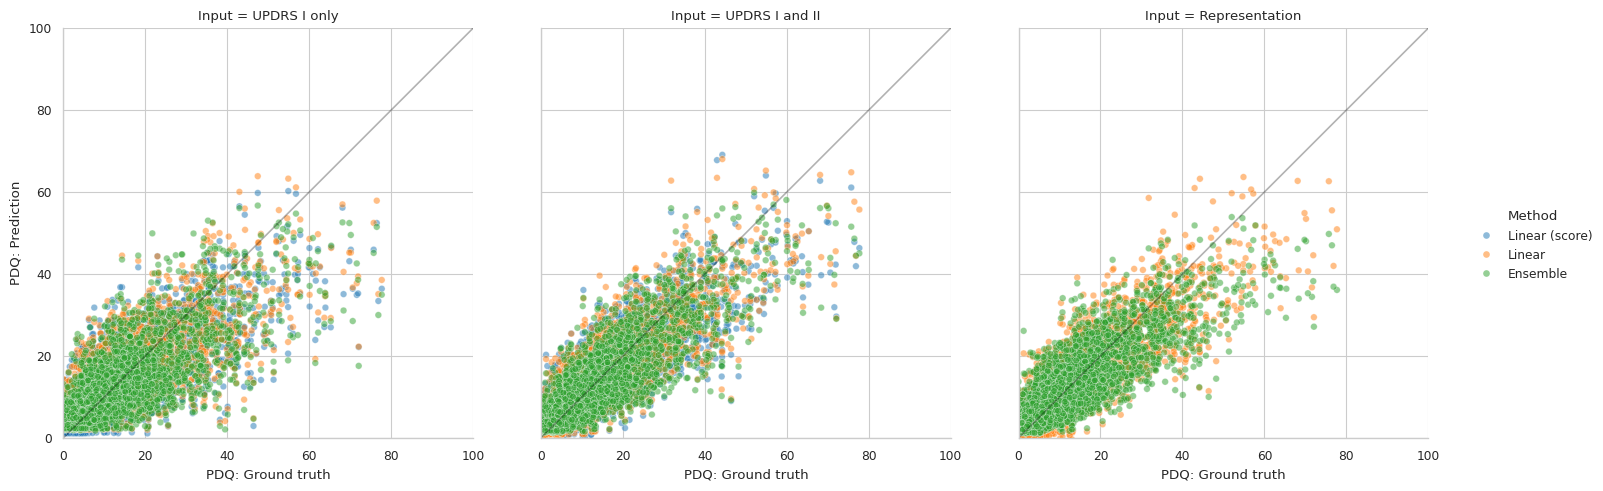

In [8]:
result = pd.concat([results_updrs_i, results_updrs_ii, representation_results])
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    grid = sns.relplot(data=result, x="PDQ: Ground truth", y="PDQ: Prediction", hue="Method", col="Input", alpha=0.5)
    grid.set(xlim=(0, 100), ylim=(0, 100), aspect="equal")
    for ax in grid.axes.flatten():
        ax.plot([0, 100], [0, 100], color="black", linestyle="-", alpha=0.3)

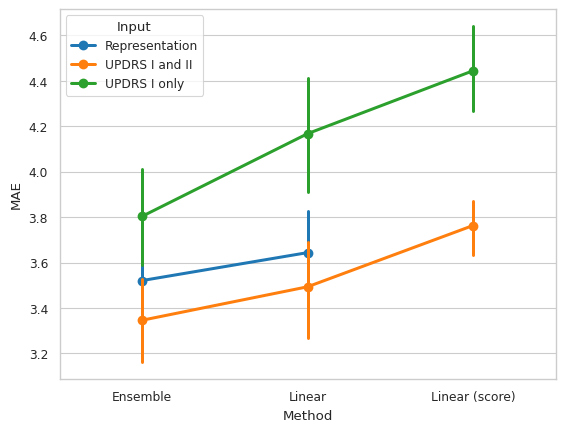

In [9]:
median_absolute_error_agg = []
for input, input_data in result.groupby("Input"):
    for name, method_data in input_data.groupby("Method"):
        folds = method_data.groupby("Fold")
        median_absolute_error_agg.append(
            pd.DataFrame.from_dict({"Method": name, "Input": input, "MAE": [median_absolute_error(y_true=fold['PDQ: Ground truth'], y_pred=fold['PDQ: Prediction']) for _, fold in folds], "Fold": range(len(folds))})
        )
median_absolute_error_agg = pd.concat(median_absolute_error_agg)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.pointplot(data=median_absolute_error_agg, x="Method", y="MAE", hue="Input")

### Calculate values on test dataset

In [10]:
def load_testdata(path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data = pd.read_csv(
        path,
        sep=",",
        na_values=[
            "Keine_Angabe",
            "Nicht_durchgeführt",
            "Keine_Angaben",
            "Keine_angabe",
        ],
    )
    pdq_columns = [column for column in data.columns if column.startswith("PDQ39 ")]
    updrs_columns = [
        column
        for column in data.columns
        if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")
    ]
    data = data[pdq_columns + updrs_columns].dropna().reset_index(drop=True)
    return data[updrs_columns], data[pdq_columns]


test_updrs, test_pdq = load_testdata(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv"
)

ground_truth = next(iter(data_module.val_dataloader()))
reconstruction = model(ground_truth.to("cuda")).x_recon
ground_truth_sum = ground_truth.sum(axis=-1).to("cuda")
reconstruction_sum = reconstruction.sum(axis=-1)

print(
    F.l1_loss(
        input=ground_truth.to("cuda"),
        target=model(ground_truth.to("cuda")).x_recon,
        reduction="none",
    )
    .sum(axis=-1)
    .mean()
    / (ground_truth.shape[-1])
)
print(
    (
        (ground_truth.to("cuda") != model(ground_truth.to("cuda")).x_recon).sum(axis=-1)
        / ground_truth.shape[-1]
    ).median()
)
print(
    torchmetrics.functional.concordance_corrcoef(
        target=ground_truth_sum.to(torch.float),
        preds=reconstruction_sum.to(torch.float),
    )
)

tensor(0.0304, device='cuda:0')
tensor(0., device='cuda:0')
tensor([0.9937], device='cuda:0')


In [9]:
reconstruction

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0')